# CPSC 302: Assignment 5
## Nicholas Hu

### Exercise 1

In [1]:
#= 
CPSC 302 Assignment 5
Nicholas Hu
=#

using Plots
pyplot()
using LaTeXStrings

In [2]:
# Function-array 'hybrid' type
immutable LSFunction <: Function
    coeffs::Vector{Float64}
    f::Function
    
    # Performs a least-squares fit given x, y, and basis functions
    # By default, the basis functions are set such that the result is a linear regression
    function LSFunction{F<:Function}(x, y, basis::Array{F}=[x->1, x->x])
        m, n = length(x), length(basis)
        A = Matrix{Float64}(m, n)
        x = Vector{Float64}(x)

        for j = 1:n
            A[:, j] = basis[j](x)
        end

        c = A \ y
        new(c, x -> sum(c[j] * basis[j](x) for j = 1:length(c)))
    end
end

# Function-like behaviour
(obj::LSFunction)(x) = obj.f(x)
# Array-like behaviour
Base.getindex(obj::LSFunction, i) = obj.coeffs[i]
Base.endof(obj::LSFunction) = endof(obj.coeffs)

# Generates an array of monomial basis functions for use in LSFunction
monomial(n::Int)::Array{Function} = [x->x.^j for j = 0:n]

monomial (generic function with 1 method)


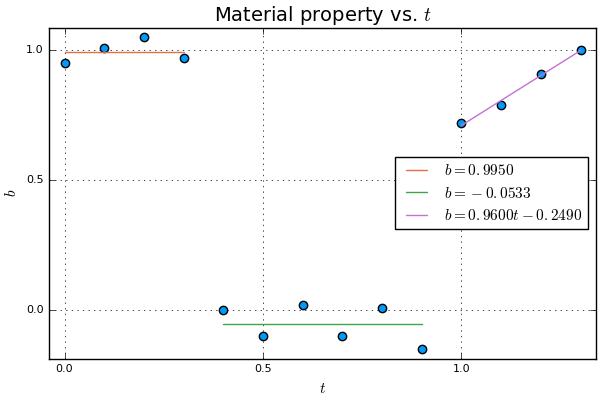

In [3]:
t = 0:0.1:1.3
b = [0.95, 1.01, 1.05, 0.97, 0.0, -0.1, 0.02, 
     -0.1, 0.01, -0.15, 0.72, 0.79, 0.91, 1.0]

scatter(t, b; label="", xlabel=L"t", ylabel=L"b", 
        title=L"Material property vs. $t$", legendfont=font(11))

# Breakpoints
piece1, piece2, piece3 = 1:4, 5:10, 11:length(t)

const1 = LSFunction(t[piece1], b[piece1], monomial(0))
const2 = LSFunction(t[piece2], b[piece2], monomial(0))
line = LSFunction(t[piece3], b[piece3])

format = s -> @sprintf("%.4f", s)
plot!(t[piece1], const1, label=latexstring("b = $(format(const1[1]))"))
plot!(t[piece2], const2, label=latexstring("b = $(format(const2[1]))"))
plot!(t[piece3], line, 
      label=latexstring("b = $(format(line[2]))t $(format(line[1]))"))

(See plot legend for equations of lines.) Roughly speaking, the first breakpoint is at $t = 0.35$; the second is at $t = 0.95$.

### Exercise 2

In [4]:
A, b = randn(20, 10), randn(20)

x_bs = A \ b
x_inv = inv(A'A)A'b
x_pinv = pinv(A)b

@printf("||x_bs - x_inv||_2   = %e\n", norm(x_bs - x_inv))
@printf("||x_bs - x_pinv||_2  = %e\n", norm(x_bs - x_pinv))
@printf("||x_inv - x_pinv||_2 = %e\n", norm(x_inv - x_pinv))

||x_bs - x_inv||_2   = 8.968101e-16
||x_bs - x_pinv||_2  = 1.648612e-15
||x_inv - x_pinv||_2 = 2.222278e-15


Indeed, the solutions are typically of distance $\lessapprox 10^{-15}$ from each other (in the 2-norm). 

In [5]:
for test in 1:10
    delta = randn(10)
    delta /= norm(delta) ^ test
    if (norm(A*(x_bs + delta) - b)^2 <= norm(A*x_bs - b)^2)
        @printf("Test %d failed!\n", test)
    end
end

We see that no tests fail (i.e., $\lVert A(\hat{x} + \vec{\delta}) - \vec{b} \rVert^2 > \lVert A\hat{x} - \vec{b} \rVert^2$ for each $\vec{\delta}$), showing that our solution indeed minimizes the (squared) norm of the residual.

### Exercise 3

In [6]:
A, b = randn(100000, 100), randn(100000)
@time A \ b;
@time A \ b;

  3.736275 seconds (1.00 k allocations: 77.374 MB, 8.61% gc time)
  4.369731 seconds (872 allocations: 77.368 MB)


Julia takes 3-4 seconds to solve a least squares problem with 100000 equations and 100 variables.

### Exercise 4


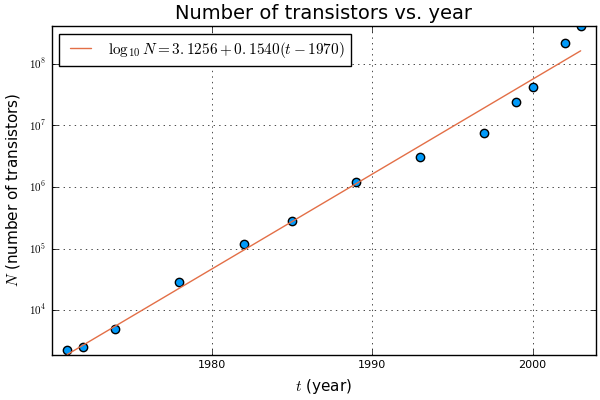

RMS Error in linear scale: 4.676014e-01
RMS Error in exponential scale: 7.529082e+07


In [7]:
t = [1971, 1972, 1974, 1978, 1982, 1985, 1989, 
     1993, 1997, 1999, 2000, 2002, 2003]
N = [2250, 2500, 5000, 29000, 120000, 275000, 1180000, 3100000, 
     7500000, 24000000, 42000000, 220000000, 410000000]

p = scatter(t, N; label="", yscale=:log10,
            xlabel=latexstring(L"t", " (year)"), 
            ylabel=latexstring(L"N", " (number of transistors)"), 
            title="Number of transistors vs. year", 
            legendfont=font(11))

lfit = LSFunction(t-1970, log10(N))
N_pred = exp10(lfit(t-1970))

plot!(t, N_pred, label=latexstring(L"\log_{10} \, N = ", 
      "\$ $(format(lfit[1])) + $(format(lfit[2])) (t-1970) \$"))
display(p)
@printf("RMS Error in linear scale: %e\n", norm(log(N_pred) - log(N)) / sqrt(length(N)))
@printf("RMS Error in exponential scale: %e\n", norm(N_pred - N) / sqrt(length(N)))

(See plot legend for the equation of the line.) The RMS error (i.e., the 2-norm of the residual divided by the square root of the number of data points) is $\sim 4.68 \times 10^{-1}$ in the linear scale and $\sim 7.53 \times 10^7$ in the exponential scale.

In [8]:
@printf("Predicted number of transistors in 2015: %e\n", exp10(lfit(2015-1970)))

Predicted number of transistors in 2015: 1.138704e+10


The linear regression predicts $\sim 1.1 \times 10^{10}$ transistors, which is slightly greater than the actual $\sim 4 \times 10^{9}$ transistors.


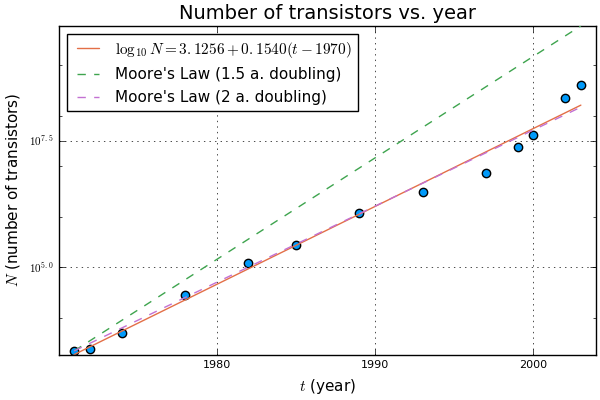

In [9]:
# Moore's Law with doubling every 1.5 years
plot!(t, N[1] * exp2((t - t[1]) / 1.5), label="Moore's Law (1.5 a. doubling)", line=:dash)
# Moore's Law with doubling every 2 years
plot!(t, N[1] * exp2((t - t[1]) / 2), label="Moore's Law (2 a. doubling)", line=:dash)

The linear regression closely matches Moore's Law with doubling every 2 years (indeed, their graphs are nearly indistinguishable).